In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pathlib

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
seaborn version: 0.11.2
GPU present


2022-01-18 14:11:28.151928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 14:11:28.161305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 14:11:28.161570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# paths to load datasets from
val_store_path = '../datasets/sa/validation'
noise_store_path = '../datasets/sa/validation_noisy'

# convert to pathlib Path objects
val_dir = pathlib.Path(val_store_path)
noise_dir = pathlib.Path(noise_store_path)

# get list of datasets in dir
val_ds_paths = sorted(list(val_dir.glob('*.csv')))
noise_ds_paths = sorted(list(noise_dir.glob('*.csv')))

# extract classification target from file names
val_ds_type = np.array([x.parts[-1].split('_')[:2] for x in val_ds_paths])
val_ds_order = [s.upper() for s in val_ds_type[:,0]]
val_ds_loc = [s.upper() for s in val_ds_type[:, 1]]

noise_ds_type = np.array([x.parts[-1].split('_')[:2] for x in noise_ds_paths])
noise_ds_order = [s.upper() for s in noise_ds_type[:,0]]
noise_ds_loc = [s.upper() for s in noise_ds_type[:, 1]]

# generate signal type tags
signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in val_ds_order])))}

In [4]:
# load the dataset(s)

# load dataset information
specs = []
datasets = []

for dataset_paths in [val_ds_paths, noise_ds_paths]:
    # temp lists for appending
    temp_specs = []
    temp_datasets = []

    for path in dataset_paths:
        print(f'loading {path}...', end=' ')

        # load dataset details
        df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
        df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')

        temp_specs.append(df_spec)

        # load data, strip unnecessary bits out
        df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
        df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
        df['I'] = df['I'].astype('float')

        print(f'loaded')

        temp_datasets.append(df)

    # append loaded datasets of each type to dataset lists
    specs.append(temp_specs)
    datasets.append(temp_datasets)

    # delete temp variables
    del temp_specs, temp_datasets, df, df_spec
    
print('done.')

loading ../datasets/sa/validation/bnet_office_val.csv... loaded
loading ../datasets/sa/validation/bnet_roof_val.csv... loaded
loading ../datasets/sa/validation/bt_library_val.csv... loaded
loading ../datasets/sa/validation/bt_office_val.csv... loaded
loading ../datasets/sa/validation/bt_room_val.csv... loaded
loading ../datasets/sa/validation/fm_roof_val.csv... loaded
loading ../datasets/sa/validation/fnet_library_val.csv... loaded
loading ../datasets/sa/validation/fnet_office_val.csv... loaded
loading ../datasets/sa/validation/fnet_room_val.csv... loaded
loading ../datasets/sa/validation/lte_library_val.csv... loaded
loading ../datasets/sa/validation/lte_office_val.csv... loaded
loading ../datasets/sa/validation/lte_room_val.csv... loaded
loading ../datasets/sa/validation/wifi_library_val.csv... loaded
loading ../datasets/sa/validation/wifi_office_val.csv... loaded
loading ../datasets/sa/validation/wifi_room_val.csv... loaded
loading ../datasets/sa/validation_noisy/bnet_office_val_noi

In [5]:
# split dataset(s) into records, extract test dataset
processed = []

# expected length of each record
rlength = 1024
    
print(f'\nType\t\tLocation\tTotal Records\tSamples/Record')
for i, zipped in enumerate(list(zip(datasets, specs, [val_ds_order, noise_ds_order], [val_ds_loc, noise_ds_loc]))):
    for dataset, spec, ds_order, ds_loc in zip(*zipped):
        nrecords = 400
        nsamples = spec.loc['NumberSamples']['info']
        ds_length = dataset.shape[0]

        # sanity check
        print(f'{ds_order:<13}\t{ds_loc:<15}\t{nrecords:<7}\t\t{nsamples:<7}')

        # loop through dataset to split 
        for j in range(nrecords):
            # extract sample length worth of samples for each record, then transpose for easier access later
            record = dataset.iloc[(nsamples * j):(nsamples * (j+1))].values.T

            # pad shorter records with random padding to rlength
            if nsamples < rlength:
                # deterine pad amount
                pad_length = rlength - nsamples
                lpad_length = np.random.randint(0, pad_length+1)
                rpad_length = pad_length - lpad_length

                # generate pad
                lpad = np.zeros((2, lpad_length))
                rpad = np.zeros((2, rpad_length))

                # concatenate pad
                record = np.concatenate([lpad, record, rpad], axis=1)

            # truncate longer records to rlength
            elif nsamples > rlength:
                record = record[:,:rlength]

            # add processed record to list
            processed.append([ds_order, signal_tags[ds_order], ds_loc, record, bool(i)])

# convert list into dataframes for later use, randomise, extract test records
df_test = pd.DataFrame(processed, columns=['signal_type', 'tag', 'location', 'record' ,'noisy']).sample(frac=1, random_state=42)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Test\t{df_test.shape[0]:<5}\t{df_test["record"].iloc[0].shape[1]}')


Type		Location	Total Records	Samples/Record
BNET         	OFFICE         	400    		1024   
BNET         	ROOF           	400    		1024   
BT           	LIBRARY        	400    		1024   
BT           	OFFICE         	400    		1024   
BT           	ROOM           	400    		1024   
FM           	ROOF           	400    		1280   
FNET         	LIBRARY        	400    		1024   
FNET         	OFFICE         	400    		1024   
FNET         	ROOM           	400    		1024   
LTE          	LIBRARY        	400    		1024   
LTE          	OFFICE         	400    		1024   
LTE          	ROOM           	400    		1024   
WIFI         	LIBRARY        	400    		1024   
WIFI         	OFFICE         	400    		1024   
WIFI         	ROOM           	400    		1024   
BNET         	OFFICE         	400    		1024   
BT           	OFFICE         	400    		1024   
FNET         	OFFICE         	400    		1024   
LTE          	OFFICE         	400    		1024   
WIFI         	OFFICE         	400    		1024   

            St

In [29]:
# df_test[df_test['signal_type'] == 'WIFI'].sample(1)['record'].values[0].shape
output = np.array(df_test[df_test['signal_type'] == 'WIFI'].sample(10)['record'].values.tolist())

with open('./output.txt', 'w') as f:
    f.write(str(output.tolist()))

    f.close()


In [6]:
# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        result = np.zeros(n_cat)
        result[n] = 1

        output.append(result)

    return np.array(output, dtype=int)

In [7]:
# load model for evaluation here
model = tf.keras.models.load_model('../saved_models/SA_resnet')

2022-01-04 14:50:16.519092: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 14:50:16.519737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 14:50:16.519897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 14:50:16.520038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

performing evaluation for OVERALL... 

2022-01-04 14:50:18.277518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-04 14:50:18.895161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-01-04 14:50:19.506014: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-04 14:50:19.506490: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-04 14:50:19.506503: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-01-04 14:50:19.506961: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-04 14:50:19.506994: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

done.
performing evaluation for ROOF... done.
performing evaluation for LIBRARY... done.
performing evaluation for ROOM... done.
performing evaluation for OFFICE... done.

METRICS
Location	Loss		Accuracy	Precision	Recall		F1 Score
OVERALL        	0.03771        	0.97317        	0.97350        	0.97317        	0.97311
ROOF           	0.00700        	0.99750        	1.00000        	0.99750        	0.99875
LIBRARY        	0.02437        	0.97750        	0.98423        	0.97750        	0.98052
ROOM           	0.03516        	0.97188        	0.97654        	0.97188        	0.97400
OFFICE         	0.06271        	0.96100        	0.96274        	0.96100        	0.96123

CORRECT VS ACTUAL
Location	BNET		BT		FM		FNET		LTE		WIFI		
OVERALL        	788/800     	1133/1200    	398/400     	1130/1200    	1192/1200    	1198/1200    	
ROOF           	400/400     	0/0       	398/400     	0/0       	0/0       	0/0       	
LIBRARY        	0/0       	392/400     	0/0       	374/400     	400/400     	398/40

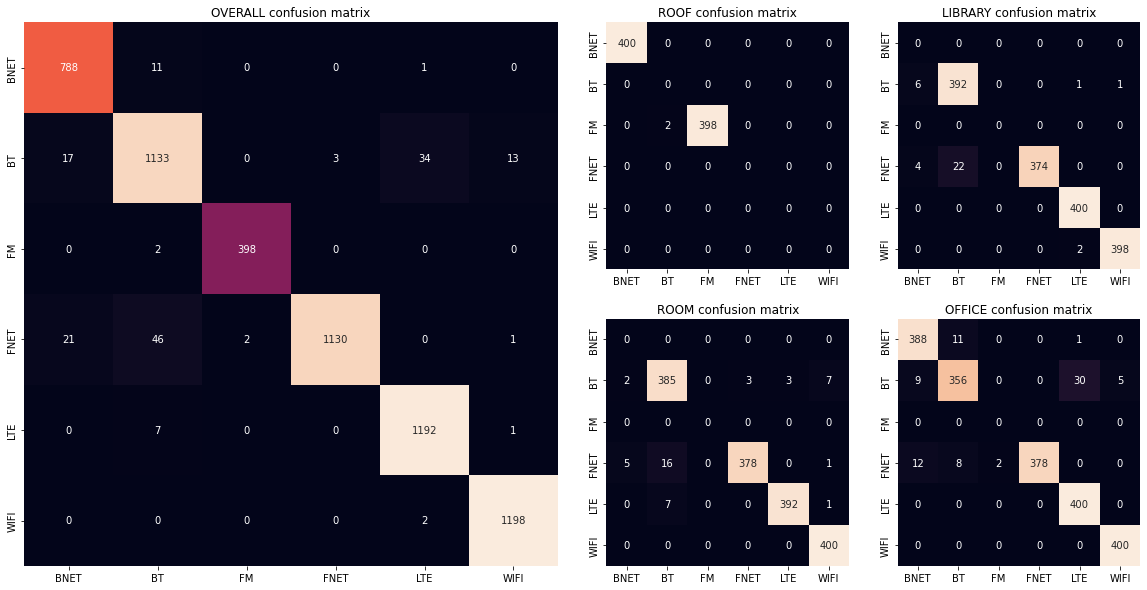

In [8]:
from sklearn.metrics import precision_recall_fscore_support

# plot confusion matrices, get precision, recall and F1 scores for each location, get correct vs total records
metrics = []
pinfo = []

fig = plt.figure(1, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)

# plot confusion matrix for entire dataset

# extract clean val data subset
df_clean = df_test[~df_test['noisy']].copy()

X_val_all = np.concatenate(df_clean['record'].values).reshape((df_clean.shape[0], 2, rlength, 1))
y_val_all = one_hot(df_clean['tag'].values, len(signal_tags))
cm_truth_all = df_clean['tag'].values

# get evaluation results
print(f'performing evaluation for OVERALL...', end=' ')
results_all = model.evaluate(X_val_all, y_val_all, verbose=0)
cm_pred_all = np.argmax(model.predict(X_val_all), axis=1)

metrics.append(['OVERALL', results_all[0], results_all[1], precision_recall_fscore_support(cm_truth_all, cm_pred_all, average='weighted', zero_division=0)[:3]])

# generate matrix
tags = list(signal_tags.keys())
df_cm_all = pd.DataFrame(tf.math.confusion_matrix(cm_truth_all, cm_pred_all, num_classes=len(tags)).numpy(), index=tags, columns=tags)

# get total amount of records, as well as count of correctly predicted records
pinfo.append(['OVERALL', [df_cm_all.iloc[i, i] for i in range(len(tags))], [df_clean[df_clean['signal_type'] == signal].shape[0] for signal in tags]])

# plot matrix
ax = fig.add_subplot(gs[:, :2])
sns.heatmap(df_cm_all, annot=True, fmt='d', ax=ax, cbar=False)
ax.set_title(f'OVERALL confusion matrix')

print(f'done.')



# plot confusion matrices for each collection location
for i, location in enumerate(df_clean['location'].unique()):
    # select location subset from combined dataset
    df_eval = df_clean[df_clean['location'] == location]
    
    # process data into correct input format
    X_val = np.concatenate(df_eval['record'].values).reshape((df_eval.shape[0], 2, rlength, 1))
    y_val = one_hot(df_eval['tag'].values, len(signal_tags))
    cm_truth = df_eval['tag'].values
    
    # get evaluation results
    print(f'performing evaluation for {location}...', end=' ')
    results = model.evaluate(X_val, y_val, verbose=0)
    cm_pred = np.argmax(model.predict(X_val), axis=1)
    
    metrics.append([location, results[0], results[1], precision_recall_fscore_support(cm_truth, cm_pred, average='weighted', zero_division=0)[:3]])
    
    # generate matrix
    df_cm = pd.DataFrame(tf.math.confusion_matrix(cm_truth, cm_pred, num_classes=len(tags)).numpy(), index=tags, columns=tags)
    
    # get total amount of records, as well as count of correctly predicted records
    pinfo.append([location, [df_cm.iloc[i, i] for i in range(len(tags))], [df_eval[df_eval['signal_type'] == signal].shape[0] for signal in tags]])

    # plot matrix
    ax = fig.add_subplot(gs[(i//2), (2 + i%2)])
    sns.heatmap(df_cm, annot=True, fmt='d', ax=ax, cbar=False)
    ax.set_title(f'{location} confusion matrix')
    
    print(f'done.')

# print scores for each location
print(f'\nMETRICS\nLocation\tLoss\t\tAccuracy\tPrecision\tRecall\t\tF1 Score')
for location, loss, accuracy, scores in metrics:
    print(f'{location:<15}\t{loss:<15.5f}\t{accuracy:<15.5f}\t{scores[0]:<15.5f}\t{scores[1]:<15.5f}\t{scores[2]:<7.5f}')
    
# print prediction information
pstr = f'\nCORRECT VS ACTUAL\nLocation\t'
for s in tags:
    pstr += f'{s}\t\t'
print(pstr)

for location, pred, actual in pinfo:
    prow = f'{location:<15}\t'
    for i in range(len(pred)):
        prow += f'{pred[i]}/{actual[i]:<8}\t'
    print(prow)


plt.show()

performing evaluation for noisy data... 
METRICS
Loss		Accuracy	Precision	Recall		F1 Score
0.73806        	0.31250        	0.30777        	0.31250        	0.19667
done.


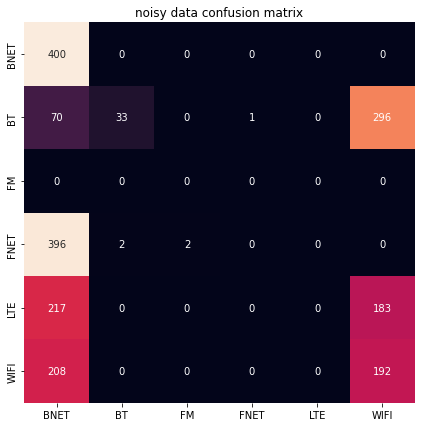

In [9]:
# construct metrics for noisy data
df_eval = df_test[df_test['noisy']].copy()
    
# process data into correct input format
X_val = np.concatenate(df_eval['record'].values).reshape((df_eval.shape[0], 2, rlength, 1))
y_val = one_hot(df_eval['tag'].values, len(signal_tags))
cm_truth = df_eval['tag'].values

# get evaluation results
print(f'performing evaluation for noisy data...', end=' ')
results = model.evaluate(X_val, y_val, verbose=0)
cm_pred = np.argmax(model.predict(X_val), axis=1)


# print metrics
scores = precision_recall_fscore_support(cm_truth, cm_pred, average='weighted', zero_division=0)[:3]
print(f'\nMETRICS\nLoss\t\tAccuracy\tPrecision\tRecall\t\tF1 Score')
print(f'{results[0]:<15.5f}\t{results[1]:<15.5f}\t{scores[0]:<15.5f}\t{scores[1]:<15.5f}\t{scores[2]:<7.5f}')

# generate matrix
df_cm = pd.DataFrame(tf.math.confusion_matrix(cm_truth, cm_pred, num_classes=len(tags)).numpy(), index=tags, columns=tags)

# plot matrix
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
sns.heatmap(df_cm, annot=True, fmt='d', ax=ax, cbar=False)
ax.set_title(f'noisy data confusion matrix')

print('done.')